## Notebook to show how BO works when tuning the aberration corrector

In [20]:
# Import tensorflow for the CNN and limit the memory usage
import tensorflow as tf
import os

gpus = tf.config.experimental.list_physical_devices('GPU')
os.environ["CUDA_VISIBLE_DEVICES"]="1" # specify which GPU to use
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
  except RuntimeError as e:
    print(e)

In [22]:
device = "cpu"

In [2]:
# Load necessary libraries
import torch
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_model
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.optim import optimize_acqf
from botorch.acquisition import UpperConfidenceBound
from botorch.models.transforms.outcome import Standardize

import time
import numpy as np
import matplotlib.pyplot as plt

In [103]:
path = '../../../NionData/110121/Defocus_attempt02_C10_250ms_standardize_normalize/'
abr_list = ["C10", "C12.x", "C12.y", "C21.x", "C21.y", "C23.x", "C23.y", "C30","C32.x", "C32.y", "C34.x", "C34.y"]
abr_lim = [2e-6, 1.5e-7, 1.5e-7, 3e-6, 3e-6, 1e-5, 1e-5, 3e-4, 2e-4, 2e-4, 1.5e-4, 1.5e-4]
act_list = [True, False, False, False, False, False, False, False, False, False, False, False]
ndim = sum(act_list)
abr_lim = [abr_lim[i] for i in range(len(abr_list)) if act_list[i]]
abr_list = [abr_list[i] for i in range(len(abr_list)) if act_list[i]]
idx_list = [0,1,2,3,4,5]
idx_list = [i for i in range(4)]
nrep = len(idx_list)

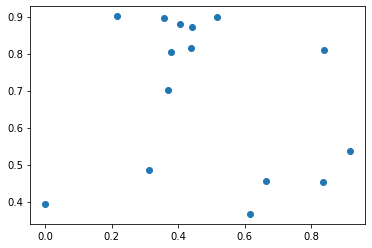

In [174]:
train_X = np.load(path + 'Defocus_45mrad_500ms_standardize_1_X.npy')
train_Y = np.load(path + 'Defocus_45mrad_500ms_standardize_1_Y.npy')
plt.scatter(train_X[:15,:], train_Y[:15,:])

In [223]:
train_X = np.load(path + 'Defocus_45mrad_500ms_standardize_1_X.npy')
train_Y = np.load(path + 'Defocus_45mrad_500ms_standardize_1_Y.npy')
outcome_transformer = Standardize( m = 1,
    batch_shape = torch.Size([]),
    min_stdv = 1e-08)
# extract part of the data as training data
train_X = torch.tensor(train_X[:20,:])
train_Y = torch.tensor(train_Y[:20,:])
# build a single task GP with the training data points
# gp = SingleTaskGP(train_X, train_Y, outcome_transform = outcome_transformer)
gp = SingleTaskGP(train_X, train_Y)

mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
fit_gpytorch_model(mll)
bounds = torch.stack([torch.zeros(1, device = device), torch.ones(1, device = device)])

In [224]:
UCB = UpperConfidenceBound(gp, beta = 2)    
candidate, acq_value = optimize_acqf(
    UCB, bounds=bounds, q = 1, num_restarts=5, raw_samples=20,
)

In [225]:
mean_list = []
var_list = []
acq_func_list = []

for i in range(100):
    
    UCB = UpperConfidenceBound(gp, beta = 0)
    val = torch.tensor([i / 100]).unsqueeze(-1)
    mean = UCB.forward(val)
    
    UCB = UpperConfidenceBound(gp, beta = 1)
    var = UCB.forward(val)
    var -= mean
    mean_list.append(mean.cpu().detach().numpy()[0])
    var_list.append(var.cpu().detach().numpy()[0])
    
    UCB = UpperConfidenceBound(gp, beta = 2)
    acq_func = UCB.forward(val)
    acq_func_list.append(acq_func.cpu().detach().numpy()[0])
    
mean_list = np.array(mean_list)
var_list = np.array(mean_list)
acq_fun_list = np.array(acq_func_list)

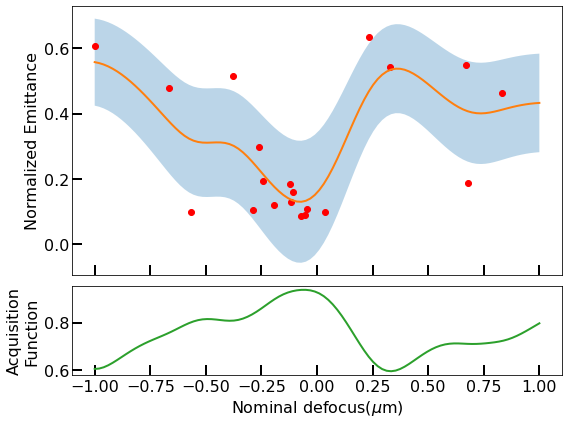

In [227]:
fig, (ax, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 6), gridspec_kw={'height_ratios': [3, 1]})
x_val = (np.linspace(0, 1, 100) - 0.5) * 2

ax.fill_between(x_val, 1 - mean_list - np.sqrt(var_list)*0.2, 
                1 - mean_list + np.sqrt(var_list) * 0.2, alpha = 0.3)
ax.plot(x_val, 1 - mean_list, c = 'C1', linewidth = 2)
ax.scatter((train_X - 0.5) * 2, 1 - train_Y, c = 'r')
ax.set_ylabel("Normalized Emittance", fontsize = 16)
ax.tick_params(which='major',direction = 'in', length = 10, width = 2, labelsize = 16)
ax.tick_params(which='minor',direction = 'in', length = 5)

ax2.plot(x_val, acq_func_list, c = "C2", linewidth = 2)
ax2.set_xlabel(r'Nominal defocus($\mu$m)', fontsize = 16)
ax2.set_ylabel("Acquisition\nFunction", fontsize = 16)
ax2.tick_params(which='major',direction = 'in', length = 10, width = 2, labelsize = 16)
ax2.tick_params(which='minor',direction = 'in', length = 5)

fig.tight_layout()
fig.savefig("BO_1D_example.png")